In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random;
import math;
from PIL import Image
import torch.onnx as torch_onnx
import PIL

模型选择之前预测正确率最高的WRN40-4（dropout=0.5)模型

In [2]:
##WRN40-4 （dropout=0.5)模型
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv0 = nn.Conv2d(1,3,kernel_size=1,stride=1)   ##
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv0(x)
        out = self.conv1(out)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

导入已经训练好的模型参数

In [3]:
import torch.optim as optim
cnn = WideResNet(40, 10, 4, 0.5)
cnn.load_state_dict(torch.load('net_paramet_WRN_normalization.pkl'))

导入自定义图像，图像文件夹路径可更改

In [4]:
import os
import matplotlib.pyplot as plt
transform = transforms.Compose(
    [
    transforms.Resize(29),  #将图像的短边缩放成29个像素，长边按短边比例缩放
    transforms.RandomCrop(28),  #随机裁剪成28*28
    transforms.ToTensor(), 
     transforms.Normalize(mean=[.2861], std=[.3530])  #mean和std采用与训练WRN网络时相同的取值
    ])
def get_files(directory):
    return [os.path.join(directory, f) for f in sorted(list(os.listdir(directory)))
            if os.path.isfile(os.path.join(directory, f))]
images = np.array([])
file = get_files('C:/Users/15273/Desktop/figure')
for i, item in enumerate(file):
    print('Processing %i of %i (%s)' % (i+1, len(file), item))
    image = transform(PIL.ImageOps.invert(Image.open(item).convert('L')))
    images = np.append(images, image.numpy())        
img = images.reshape(-1, 1, 28, 28)
img = torch.from_numpy(img).float()

Processing 1 of 2 (C:/Users/15273/Desktop/figure\fig1.jpg)
Processing 2 of 2 (C:/Users/15273/Desktop/figure\fig2.jpg)


显示输入的自定义图像

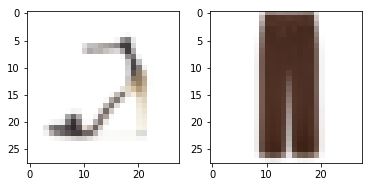

In [5]:
transform = transforms.Compose(
    [
    transforms.Resize(29),  #将图像的短边缩放成29个像素，长边按短边比例缩放
    transforms.RandomCrop(28),  #随机裁剪成28*28
    ])
def get_files(directory):
    return [os.path.join(directory, f) for f in sorted(list(os.listdir(directory)))
            if os.path.isfile(os.path.join(directory, f))]
images = np.array([])
file1 = get_files('C:/Users/15273/Desktop/figure')
for i, item in enumerate(file1):
    plt.subplot(1,2,i+1)
    image = transform(Image.open(item))
    plt.imshow(image)

对图像进行预测

In [6]:
import time

time_start=time.time()
outputs = cnn(img)
time_end=time.time()
print('time cost',time_end-time_start,'s')
_, predicted = torch.max(outputs, 1)
print(outputs)
classes = ('T-shirt', 'Trouser', 'Pollover', 'Dress',
           'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle boot')
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(i+1)))

time cost 0.23844671249389648 s
tensor([[ 1.2746, -2.7013,  1.3807, -0.2298, -1.8902,  2.2516,  2.0645, -0.2736,
         -0.4326, -1.4464],
        [-0.6153,  2.4787, -1.2158,  0.4734,  1.6364, -2.8482, -1.3431, -0.0835,
          0.1115,  1.4012]], grad_fn=<AddmmBackward>)
Predicted:  Sandal Trouser
